# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

## Project Overview

Sparkify is music streaming service like Spotify. Users can listen music using free plan with ads, or they can upgrade to paid plan without ads. Other than listening music, users can vote up and down, add songs to playlist and add friends. If they don't like the paid plan, they can downgrade or they can completely cancel the plan

All user activities are kept with log files. We are able to get informatin such as sessions, pages, user info, subscription plan etc.


## Problem Statement

Our aim to find which users are possibly going to leave our service. We'll define churned users with either "downgrade" or "cancelled" logs

Definin potential churned user is a binary classification problem. we'll have only two label values as churned or non-churned
The solution of our problem is to create a machine learning model that can provide prediction results achieving the project goal according to the chosen metrics as described in the next section.

## Metrics

Our dataset is imbalanced which means churned user data is low compared to non-churned users. Labels are not distributed equally so it's not enough use only accuracy of model.

We'll use f1 score to check performance our model to balance precision and recall values

In [1]:
# import libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import TimestampType, LongType, DateType, IntegerType
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import time
import numpy as np

In [2]:
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, \
    NaiveBayes, DecisionTreeClassifier

In [4]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

22/02/04 18:24:04 WARN Utils: Your hostname, uerten resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
22/02/04 18:24:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/04 18:24:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
df = spark.read.json("mini_sparkify_event_data.json")

In [6]:
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
df.count()

286500

In [9]:
print("Null or empty cell counts:")
for column in df.columns:
    print(column, ":", df.where((df[column] == "") | (df[column].isNull())).count())

Null or empty cell counts:
artist : 58392
auth : 0
firstName : 8346
gender : 8346
itemInSession : 0
lastName : 8346
length : 58392
level : 0
location : 8346
method : 0
page : 0
registration : 8346
sessionId : 0
song : 58392
status : 0
ts : 0
userAgent : 8346
userId : 8346


In [10]:
# filter empty and null rows of userId and sessionId columns
df = df.filter((df.userId != "") & (~df.userId.isNull()))

In [11]:
print("Null or empty cell counts:")
for column in df.columns:
    print(column, ":", df.where((df[column] == "") | (df[column].isNull())).count())

Null or empty cell counts:
artist : 50046
auth : 0
firstName : 0
gender : 0
itemInSession : 0
lastName : 0
length : 50046
level : 0
location : 0
method : 0
page : 0
registration : 0
sessionId : 0
song : 50046
status : 0
ts : 0
userAgent : 0
userId : 0


In [12]:
df.select("userId").describe().show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           278154|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|               10|
|    max|               99|
+-------+-----------------+



In [13]:
df.count()

278154

In [14]:
df.groupby("page").count().sort(F.desc("count")).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



In [15]:
df.groupby("auth").count().sort(F.desc("count")).show()

+---------+------+
|     auth| count|
+---------+------+
|Logged In|278102|
|Cancelled|    52|
+---------+------+



In [16]:
df.groupby("level").count().sort(F.desc("count")).show()

+-----+------+
|level| count|
+-----+------+
| paid|222433|
| free| 55721|
+-----+------+



In [17]:
df.groupby("method").count().sort(F.desc("count")).show()

+------+------+
|method| count|
+------+------+
|   PUT|257818|
|   GET| 20336|
+------+------+



In [18]:
df.groupby("status").count().sort(F.desc("count")).show()

+------+------+
|status| count|
+------+------+
|   200|254718|
|   307| 23184|
|   404|   252|
+------+------+



In [19]:
# genders by transactions
df.groupby("gender").count().sort(F.desc("count")).show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



In [20]:
# genders by user
df.dropDuplicates(["userId"]).groupby("gender").count().sort(F.desc("count")).show()

+------+-----+
|gender|count|
+------+-----+
|     M|  121|
|     F|  104|
+------+-----+



In [21]:
df.groupby("itemInSession").count().sort(F.desc("count")).show()

+-------------+-----+
|itemInSession|count|
+-------------+-----+
|            2| 2941|
|            3| 2917|
|            4| 2887|
|            5| 2836|
|            1| 2818|
|            6| 2803|
|            7| 2776|
|            8| 2735|
|            9| 2693|
|            0| 2689|
|           10| 2633|
|           11| 2596|
|           12| 2556|
|           13| 2513|
|           14| 2485|
|           15| 2456|
|           16| 2428|
|           17| 2385|
|           18| 2345|
|           19| 2322|
+-------------+-----+
only showing top 20 rows



In [22]:
# session counts by user
df.select("userId", "sessionId") \
    .groupby("userId") \
    .agg(F.countDistinct("sessionId").alias("count")) \
    .sort("count", ascending=False) \
    .show()

+------+-----+
|userId|count|
+------+-----+
|    39|  107|
|    92|   86|
|300011|   76|
|200023|   76|
|   140|   71|
|300017|   63|
|300021|   58|
|    42|   47|
|    85|   41|
|    35|   38|
|    54|   37|
|200020|   36|
|   100|   35|
|    29|   34|
|300015|   33|
|    95|   33|
|    13|   33|
|    30|   32|
|     9|   31|
|   126|   30|
+------+-----+
only showing top 20 rows



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [23]:
df.withColumn('Churn', F.when(df.page == "Cancellation Confirmation", 1).otherwise(0)).show(10)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    L

In [24]:
# get cancelled and downgraded user ids
cancelledIds = df.filter(df.page == "Cancellation Confirmation").select("userId").dropDuplicates()
downgradedIds = df.filter(df.page == "Submit Downgrade").select("userId").dropDuplicates()

In [25]:
print("Count of cancelled ids:",cancelledIds.count())
print("Count of downgraded ids:",downgradedIds.count())

Count of cancelled ids: 52
Count of downgraded ids: 49


In [26]:
# add label column and set 1 if user is cancelled user
df_churn = df.withColumn('Churn', F.when(df.userId.isin([row.userId for row in cancelledIds.collect()]), 1).otherwise(0))

In [27]:
# add separate date & time columns
df_churn = df_churn.withColumn("datetime", F.from_unixtime(F.col('ts').cast(LongType())/1000).cast(TimestampType()))
df_churn = df_churn.withColumn('month', F.month(F.col('datetime')))
df_churn = df_churn.withColumn('hour', F.hour(F.col('datetime')))
df_churn = df_churn.withColumn('date', F.from_unixtime(F.col('ts')/1000).cast(DateType()))

In [28]:
df_churn.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-------------------+-----+----+----------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn|           datetime|month|hour|      date|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-------------------+-----+----+----------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpool

<AxesSubplot:xlabel='hour', ylabel='songcount'>

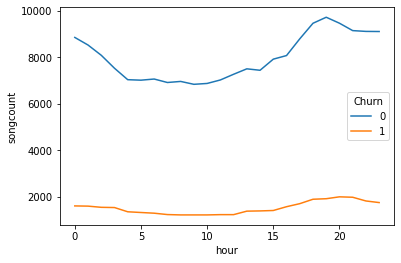

In [29]:
# Played song count of Churned vs Non-Churned users by time of day

sns.lineplot(data=df_churn.filter(df_churn.page == "NextSong") \
    .groupby(["Churn","hour"]) \
    .agg(F.count("page").alias("songcount")) \
    .sort(["Churn", "hour"]).toPandas(), x="hour", y="songcount", hue="Churn")

<AxesSubplot:xlabel='hour', ylabel='mean_songcount'>

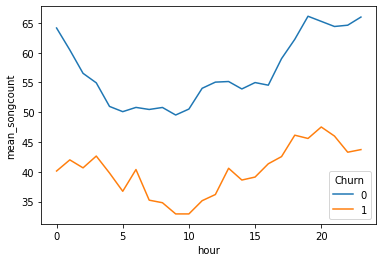

In [30]:
# Played song mean count of Churned vs Non-Churned users by time of day

sns.lineplot(data=df_churn.filter(df_churn.page == "NextSong") \
    .groupby(["Churn","userId","hour"]) \
    .agg(F.count("page").alias("songcount")) \
    .groupby("Churn","hour") \
    .agg(F.mean("songcount").alias("mean_songcount")) \
    .sort(["Churn", "hour"]).toPandas(), x="hour", y="mean_songcount", hue="Churn")

In [31]:
# days passed since registration day of users
df_churn.groupby("Churn","userId") \
    .agg((((F.max("ts") - F.max("registration"))/(1000*60*60*24)).cast('integer')).alias("days_since_register")) \
    .groupby("Churn") \
    .agg(F.mean("days_since_register").alias("mean_days_since_register")) \
    .show()

+-----+------------------------+
|Churn|mean_days_since_register|
+-----+------------------------+
|    1|       56.80769230769231|
|    0|       86.14450867052022|
+-----+------------------------+



In [32]:
# latest account level of users
df_churn.sort("ts") \
    .groupby("Churn","userId") \
    .agg(F.last("level").alias("level")) \
    .groupby("Churn", "level") \
    .agg(F.count("userId").alias("count")) \
    .sort(["level","Churn"]).show()

+-----+-----+-----+
|Churn|level|count|
+-----+-----+-----+
|    0| free|   59|
|    1| free|   21|
|    0| paid|  114|
|    1| paid|   31|
+-----+-----+-----+



In [33]:
# event count of all pages of users
df_churn.groupby(["Churn","userId","page"]) \
    .agg(F.count("page").alias("count")) \
    .groupby(["Churn","page"]) \
    .agg(F.mean("count").alias("mean_pagecount")) \
    .sort(["page", "Churn"]).show(50,truncate=False)

+-----+-------------------------+------------------+
|Churn|page                     |mean_pagecount    |
+-----+-------------------------+------------------+
|0    |About                    |3.5403225806451615|
|1    |About                    |1.8064516129032258|
|0    |Add Friend               |22.47530864197531 |
|1    |Add Friend               |14.454545454545455|
|0    |Add to Playlist          |33.26060606060606 |
|1    |Add to Playlist          |20.76             |
|1    |Cancel                   |1.0               |
|1    |Cancellation Confirmation|1.0               |
|0    |Downgrade                |14.436974789915967|
|1    |Downgrade                |9.628571428571428 |
|0    |Error                    |2.3157894736842106|
|1    |Error                    |1.4545454545454546|
|0    |Help                     |8.154362416107382 |
|1    |Help                     |5.558139534883721 |
|0    |Home                     |48.895348837209305|
|1    |Home                     |32.7843137254

In [34]:
# status counts of users
df_churn.groupby(["Churn","userId","status"]) \
    .agg(F.count("status").alias("count")) \
    .groupby("Churn","status") \
    .agg(F.mean("count").alias("mean_statuscount")) \
    .sort(["status","Churn"]).show()

+-----+------+------------------+
|Churn|status|  mean_statuscount|
+-----+------+------------------+
|    0|   200|1234.5722543352601|
|    1|   200| 791.0961538461538|
|    0|   307|113.97076023391813|
|    1|   307|  71.0576923076923|
|    0|   404|2.3157894736842106|
|    1|   404|1.4545454545454546|
+-----+------+------------------+



In [35]:
# total event count of users
df_churn.groupby(["Churn","userId"]) \
    .agg(F.count("page").alias("count")) \
    .groupby(["Churn"]) \
    .agg(F.mean("count").alias("mean_totaleventcount")) \
    .show()

+-----+--------------------+
|Churn|mean_totaleventcount|
+-----+--------------------+
|    1|   862.7692307692307|
|    0|  1348.4971098265896|
+-----+--------------------+



In [36]:
# mean song length of users
df_churn.groupby(["Churn"]) \
    .agg(F.mean("length").alias("mean_length")) \
    .show()

+-----+------------------+
|Churn|       mean_length|
+-----+------------------+
|    1|248.63279564406366|
|    0|249.20913538881427|
+-----+------------------+



In [37]:
# mean session time of users
df_churn.groupby(['Churn','userId','sessionId']) \
    .agg(F.min("ts").alias("session_start"), F.max("ts").alias("session_end")) \
    .withColumn("sessiontime", (F.col("session_end") - F.col("session_start")) / 1000) \
    .groupby(["Churn"]) \
    .agg(F.mean("sessiontime").alias("mean_sessiontime")) \
    .show()

+-----+------------------+
|Churn|  mean_sessiontime|
+-----+------------------+
|    1|16987.292364990688|
|    0| 18171.32171276999|
+-----+------------------+



In [38]:
# average time gap between sessions of users
df_churn.groupby(['Churn','userId','sessionId']) \
    .agg(F.min("ts").alias("session_start"), F.max("ts").alias("session_end")) \
    .groupby(["Churn", "userId"]) \
    .agg(F.count("userId").alias('sessioncount'), ((F.max("session_end") - F.min("session_start"))/1000).alias("totaltimepassed"), (F.sum(F.col("session_end") - F.col("session_start"))/1000).alias("totalsessiontime")) \
    .withColumn("avgsessiongap", (F.col("totaltimepassed") - F.col("totalsessiontime")) / (F.col("sessioncount")-1)) \
    .groupby(["Churn"]) \
    .agg(F.mean("avgsessiongap")) \
    .show()

+-----+------------------+
|Churn|avg(avgsessiongap)|
+-----+------------------+
|    1|254732.06872084906|
|    0| 528979.8842565479|
+-----+------------------+



<AxesSubplot:xlabel='count', ylabel='Count'>

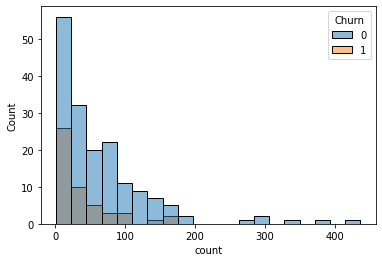

In [39]:
# Thumbs up count of churned vs non-churned users
sns.histplot(data=df_churn.filter(df_churn.page == "Thumbs Up") \
    .groupby(["Churn","userId"]) \
    .agg(F.count("page").alias("count")) \
    .toPandas(), x="count", hue="Churn")

user_window = Window \
    .partitionBy('userId') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [40]:
# Change gender value to binary values
genders = df_churn.groupby("userId") \
                .agg(F.first("gender").alias("gender")) \
                .replace(['M', 'F'], ['0', '1'], 'gender') \
                .select('userId', F.col('gender').cast('int').alias('gender'))

In [41]:
# days passed since registration day of users
days_passed = df_churn.groupby("userId") \
    .agg((((F.max("ts") - F.max("registration"))/(1000*60*60*24)).cast('integer')).alias("days_since_register"))

In [42]:
# latest account level of users
latest_level = df_churn.sort("ts") \
    .groupby("userId") \
    .agg(F.last("level").alias("level")) \
    .replace(['free', 'paid'], ['0', '1'], 'level') \
    .select('userId', F.col('level').cast('int').alias('level'))

In [43]:
# Calculate page count by users
def page_count(df,page):
    return df.filter(df["page"] == page) \
            .groupby("userId") \
            .agg(F.count("page").alias("count_" + page.replace(" ","")))

In [44]:
count_about = page_count(df_churn,"About")
count_addafriend = page_count(df_churn,"Add Friend")
count_addtoplaylist = page_count(df_churn,"Add to Playlist")
count_downgrade = page_count(df_churn,"Downgrade")
count_error = page_count(df_churn,"Error")
count_help = page_count(df_churn,"Help")
count_home = page_count(df_churn,"Home")
count_nextsong = page_count(df_churn,"NextSong")
count_rolladvert = page_count(df_churn,"Roll Advert")
count_settings = page_count(df_churn,"Settings")
count_submitdowngrade = page_count(df_churn,"Submit Downgrade")
count_submitupgrade = page_count(df_churn,"Submit Upgrade")
count_thumbsdown = page_count(df_churn,"Thumbs Down")
count_thumbsup = page_count(df_churn,"Thumbs Up")
count_upgrade = page_count(df_churn,"Upgrade")

In [45]:
# status counts by users
def status_count(df, status):
    return df.filter(df["status"] == status) \
        .groupby(["userId"]) \
        .agg(F.count("status").alias("count_status"+status))

In [46]:
count_status200 = status_count(df_churn,"200")
count_status307 = status_count(df_churn,"307")
count_status404 = status_count(df_churn,"404")

In [47]:
# total event count of users
count_totalevent = df_churn.groupby(["userId"]) \
    .agg(F.count("page").alias("count"))

In [48]:
# mean session time of users
avg_session_time = df_churn.groupby(['userId','sessionId']) \
    .agg(F.min("ts").alias("session_start"), F.max("ts").alias("session_end")) \
    .withColumn("sessiontime", (F.col("session_end") - F.col("session_start")) / 1000 / 3600) \
    .groupby("userId") \
    .agg(F.mean("sessiontime").alias("avg_session_time"))

In [49]:
# average time gap between sessions of users
avg_sessiongap_time = df_churn.groupby(['userId','sessionId']) \
    .agg(F.min("ts").alias("session_start"), F.max("ts").alias("session_end")) \
    .groupby(["userId"]) \
    .agg(F.count("userId").alias('sessioncount'), ((F.max("session_end") - F.min("session_start"))/1000/3600).alias("totaltimepassed"), (F.sum(F.col("session_end") - F.col("session_start"))/1000/3600).alias("totalsessiontime")) \
    .withColumn("avgsessiongap", (F.col("totaltimepassed") - F.col("totalsessiontime")) / (F.col("sessioncount")-1)) \
    .select("userId","avgsessiongap")

In [50]:
df_labels = df_churn.select(df_churn['userId'], df_churn["Churn"].alias('label')).dropDuplicates()

In [51]:
model_data = df_labels.join(genders, "userId", "outer") \
                    .join(days_passed, "userId", "outer") \
                    .join(latest_level, "userId", "outer") \
                    .join(count_about, "userId", "outer") \
                    .join(count_addafriend, "userId", "outer") \
                    .join(count_addtoplaylist, "userId", "outer") \
                    .join(count_downgrade, "userId", "outer") \
                    .join(count_error, "userId", "outer") \
                    .join(count_help, "userId", "outer") \
                    .join(count_home, "userId", "outer") \
                    .join(count_nextsong, "userId", "outer") \
                    .join(count_rolladvert, "userId", "outer") \
                    .join(count_settings, "userId", "outer") \
                    .join(count_submitdowngrade, "userId", "outer") \
                    .join(count_submitupgrade, "userId", "outer") \
                    .join(count_thumbsdown, "userId", "outer") \
                    .join(count_thumbsup, "userId", "outer") \
                    .join(count_upgrade, "userId", "outer") \
                    .join(count_status200, "userId", "outer") \
                    .join(count_status307, "userId", "outer") \
                    .join(count_status404, "userId", "outer") \
                    .join(count_totalevent, "userId", "outer") \
                    .join(avg_session_time, "userId", "outer") \
                    .join(avg_sessiongap_time, "userId", "outer") \
                    .drop("userId").fillna(0)

In [52]:
model_data.show(5)

+-----+------+-------------------+-----+-----------+---------------+-------------------+---------------+-----------+----------+----------+--------------+----------------+--------------+---------------------+-------------------+----------------+--------------+-------------+---------------+---------------+---------------+-----+------------------+------------------+
|label|gender|days_since_register|level|count_About|count_AddFriend|count_AddtoPlaylist|count_Downgrade|count_Error|count_Help|count_Home|count_NextSong|count_RollAdvert|count_Settings|count_SubmitDowngrade|count_SubmitUpgrade|count_ThumbsDown|count_ThumbsUp|count_Upgrade|count_status200|count_status307|count_status404|count|  avg_session_time|     avgsessiongap|
+-----+------+-------------------+-----+-----------+---------------+-------------------+---------------+-----------+----------+----------+--------------+----------------+--------------+---------------------+-------------------+----------------+--------------+---------

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [53]:
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, \
    NaiveBayes, DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import time

In [54]:
def split_data(data, seed=0):
    """
    Splits data into train and test data 80:20 ratip
    
    Input:
    data [DataFrame]: Data with features
    seed [int]: seed number for generator
        
    Output:
    train [DataFrame]: Train dataset
    test [DataFrame]: Test dataset.
    """
    train, test = data.randomSplit([0.8, 0.2], seed=seed);
    return train, test

def create_pipeline(data, classifier, scaler):
    """
    Create pipeline
    
    Input:
    data [Dataframe]: Data with features
    classifier: Machine learning classifier

    Returns:
    pipeline: Created pipeline
    """
    features = data.drop('label').columns
    assembler = VectorAssembler(inputCols=features, outputCol='NumFeatures')
    pipeline = Pipeline(stages=[assembler, scaler, classifier]);

    return pipeline

In [55]:
def fit_model(data, classifier, seed=0):
    """
    Fit model and calculate metrics
    
    Input:
    data [Dataframe]: Data with features
    classifier: Machine learning classifier
    seed [int]: seed number for generator
        
    Output:
    model: The fitted model.
    metrics: The fitted model's metrics.
    """
    start_time = time.time()
    print('Model preparation is starting...')
    # Split data into train and test subset
    train, test = split_data(data, seed)
    print('Dataset split is done.')

    # Create pipeline
    scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
    pipeline = create_pipeline(data, classifier, scaler)
    print('Pipeline creation is done')

    # Train model
    model = pipeline.fit(train)
    print('Training is done')

    # Get metrics
    metrics = calc_metrics(model, test)
    print('Metric preparation is done.')

    fitting_duration = time.time() - start_time
    
    print(f'Model fitting is done ({int(fitting_duration)} s).')
    
    return model, metrics

In [56]:
def calc_metrics(model, test):
    """
    Calculates the metrics of the specified model.
    
    Input:
    model: Fitted model
    test: test/validation dataset
        
    Output:
    metrics: Calculated metrics
    """
    # Create both evaluators
    evaluatorMulti = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')
    evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')

    # Make predicitons
    prediction = model.transform(test).select('label', 'prediction')

    # Get metrics
    acc = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: 'accuracy'})
    f1 = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: 'f1'})
    weightedPrecision = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: 'weightedPrecision'})
    weightedRecall = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: 'weightedRecall'})
    auc = evaluator.evaluate(prediction)
    
    metrics = pd.DataFrame(index=['F1', 'accuracy', 'weighted precision', 'weighted recall', 'AUC'], \
                           data={'metrics value': [f1, acc, weightedPrecision, weightedRecall, auc]})
    
    return metrics

In [57]:
# Plot feature importances
def plot_feature_importance(data, model, height, title):
    features = data.drop('label').columns
    feature_coeff = model.stages[-1].featureImportances
    feature_importances = pd.DataFrame(list(zip(features, feature_coeff)), \
                                       columns=['Feature', 'FeatureImportances']) \
        .sort_values('FeatureImportances', ascending=False)

    values = feature_importances.sort_values(by='FeatureImportances', ascending=False)['FeatureImportances']
    labels = feature_importances.sort_values(by='FeatureImportances', ascending=False)['Feature']

    plt.figure(figsize = [8, height])
    plt.barh(np.arange(len(values)), values, height=0.6)
    ax = plt.gca()
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('FeatureImportances')
    ax.set_ylabel('Features')
    ax.set_title(title)
    plt.grid(True, axis='x', linewidth= 1, linestyle="--")

    plt.show()

In [58]:
classifier = LogisticRegression(featuresCol='features', labelCol = 'label')
model_lr, metrics_lr = fit_model(model_data, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.


22/02/04 18:25:21 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/02/04 18:25:42 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/02/04 18:25:42 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Training done.


Metrics prepared.
Model fitting done (70 s).


In [59]:
metrics_lr

,metrics value
F1,0.796145
accuracy,0.800000
weighted precision,0.793210
weighted recall,0.800000
AUC,0.692857


In [60]:
classifier = RandomForestClassifier(seed=5)
model_rfc, metrics_rfc = fit_model(model_data, classifier, seed=5)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.


Training done.


Metrics prepared.
Model fitting done (66 s).


In [61]:
metrics_rfc

,metrics value
F1,0.885128
accuracy,0.903226
weighted precision,0.913237
weighted recall,0.903226
AUC,0.700000


In [62]:
classifier = GBTClassifier()
model_gbt, metrics_gbt = fit_model(model_data, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.


Training done.


Metrics prepared.
Model fitting done (54 s).


features = model_data.drop('label').columns
assembler = VectorAssembler(inputCols=features, outputCol='NumFeatures')
scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
classifier = GBTClassifier()
pipeline = Pipeline(stages=[assembler, scaler, classifier])

In [63]:
metrics_gbt

,metrics value
F1,0.739010
accuracy,0.755556
weighted precision,0.729741
weighted recall,0.755556
AUC,0.592857


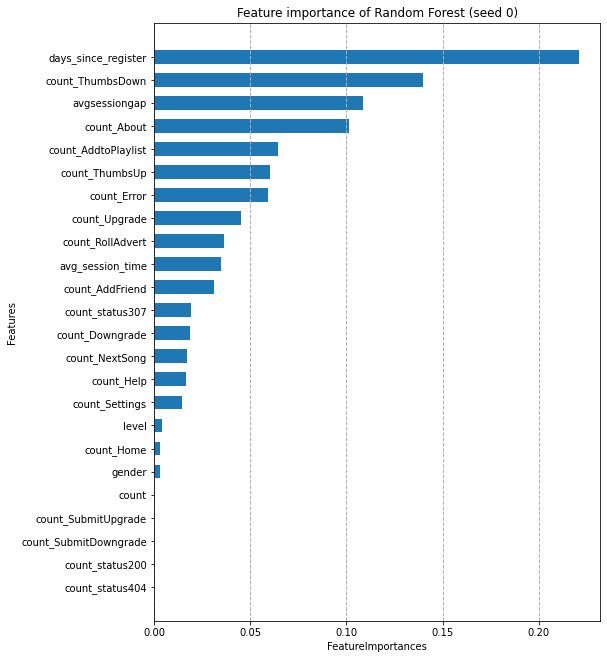

In [64]:
plot_feature_importance(model_data, model_gbt, 11, 'Feature importance of Random Forest (seed 0)')

In [65]:
# Cross Validation
print('Cross validation started. Please wait...')

# Create classifier
gbt = GBTClassifier(seed=0)

# Create pipeline
scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
pipeline = create_pipeline(model_data, gbt, scaler)

# Define params
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 50]) \
    .addGrid(gbt.maxDepth,[2, 5]) \
    .addGrid(gbt.maxBins, [32]) \
    .build()

# Create cross validator
crossval_gbt = CrossValidator(estimator = pipeline,
                              estimatorParamMaps = paramGrid_gbt,
                              evaluator = MulticlassClassificationEvaluator(),
                              numFolds = 2)

# Fit model
start_time = time.time()
crossval_model_gbt = crossval_gbt.fit(split_data(model_data)[0]) # train
duration = time.time() - start_time

print(f'Cross validation done ({int(duration)} s).')

# Show best params
print('\nCross validation parameters ordered by score, descending:')
scores = crossval_model_gbt.avgMetrics
params = [{p.name: v for p, v in m.items()} for m in crossval_model_gbt.getEstimatorParamMaps()]
params_df = pd.DataFrame(params)
params_df['score'] = scores
params_df.sort_values(by='score', ascending=False)

Cross validation started. Please wait...


22/02/04 19:15:52 WARN BlockManager: Asked to remove block broadcast_4797, which does not exist


Cross validation done (3287 s).

Cross validation parameters ordered by score, descending:


,maxIter,maxDepth,maxBins,score
0,10,2,32,0.804454
2,50,2,32,0.780504
3,50,5,32,0.762272
1,10,5,32,0.758355


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.